In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import ot

# Covariance Matrix

In [ ]:
def rbf_kernel(x1, x2, width=1.0):
    sq_dist = np.sum((x1 - x2) ** 2)
    return np.exp(-width * sq_dist)

In [ ]:
def sample_gaussian_process(x_values, width, x_test=None):
    num_points = len(x_values)

    # Compute the covariance matrix (Gram matrix) using the RBF kernel for training points
    K = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            K[i, j] = rbf_kernel(x_values[i], x_values[j], width)

    # Generate a sample from the prior Gaussian process
    mean_prior = np.zeros(num_points)
    sample_prior = np.random.multivariate_normal(mean_prior, K)
    if x_test is None:
        return sample_prior

    # Compute the covariance matrix between training and test points
    K_star = np.zeros((num_points, len(x_test)))
    for i in range(num_points):
        for j in range(len(x_test)):
            K_star[i, j] = rbf_kernel(x_values[i], x_test[j], width)

    # Compute the covariance matrix for test points
    K_test = np.zeros((len(x_test), len(x_test)))
    for i in range(len(x_test)):
        for j in range(len(x_test)):
            K_test[i, j] = rbf_kernel(x_test[i], x_test[j], width)

    # Calculate the mean and covariance of the predictive distribution
    mean_test = np.dot(K_star.T, np.linalg.solve(K, sample_prior))
    return mean_test


These are the GT parameters

In [ ]:
mu_0 = 1
mu_tau = 0.1

Generate training $x$. Assume $X_\text{tst}$ = $X_0 \cup X_1$

In [ ]:
n0 = 4
n1= 5
n = n0+n1

x_0 = np.random.normal(-0.5, 0.5, n0)
x_1 = np.random.normal(0.5, 0.5, n1)
x_test = np.concatenate([x_0, x_1])

f0_tst = sample_gaussian_process(x_values=x_test, width=mu_0)
f0_star = f0_tst[:n0]
ftau_tst = sample_gaussian_process(x_values=x_test, width=mu_tau)
f1_tst = f0_tst + ftau_tst
f1_star = f1_tst[n0:]
print(x_0)
print(x_1)
print(ftau_tst)

In [ ]:
argsort = np.argsort(x_test)
plt.plot(x_test[argsort], f0_tst[argsort], label="f0_tst")
plt.plot(x_test[argsort], ftau_tst[argsort], label="ftau_tst")
plt.plot(x_test[argsort], f1_tst[argsort], label="f1_tst")
plt.legend()
plt.show()

In [ ]:
def std_norm(df, column):
    c = df[column]
    df[f"{column}-std"] = (c - c.mean())/c.std()

In [ ]:
def OT_distances(x_0, x_1):
    if x_0.ndim == 1:
        x_0 = x_0.reshape(-1, 1)
    if x_1.ndim == 1:
        x_1 = x_1.reshape(-1, 1)

    M = ot.dist(x_0, x_1)
    # print("cost: ", M.shape)
    # print(M)

    # Assume uniform distribution
    a = np.ones(len(x_0)) / len(x_0)
    b = np.ones(len(x_1)) / len(x_1)

    lambd = 1e-1
    Gs = ot.sinkhorn(a, b, M, lambd)
    print("Transport matrix: ", Gs.shape)
    # print(Gs)
    return Gs

# sinkhorn

In [ ]:
dists = np.abs(x_0.reshape(-1, 1) - x_1.reshape(1, -1))
assert dists.shape == (n0, n1)

nbrs_0 = np.argmin(dists, axis=1)
assert len(nbrs_0) == n0
nbrs_1 = np.argmin(dists, axis=0)
assert len(nbrs_1) == n1
# print(dists)
# print(nbrs_0)
# print(nbrs_1)

sinkhorn = OT_distances(x_0, x_1)

mindiffloss = 100
minfloss = 100
for method in ["nbrs", "ot"]:
    print("****"*10, method, "****"*10)
    for arbitrary_fn in [True, False]:
        results_dict = {
        "mu_0": [],
        "mu_tau": [],
        "floss": [],
        "diffloss": [],
        "true_loss": [],
        }
        np.random.seed(3)
        for mu_0_hat in [1]: #, 1.5]:
            for mu_tau_hat in [0.1]: #, 0.25]:
                for ns in [1, 2, 3, 4, 5, 7, 8, 9, 10]:
                    if arbitrary_fn == True:
                        f0_hat = sample_gaussian_process(x_test, width=mu_0_hat) # + np.random.randn(n) * 0.2
                        ftau_hat = sample_gaussian_process(x_test, width=mu_tau_hat)
                        f1_hat = f0_hat + ftau_hat # + np.random.randn(n) * 0.2
                    else:
                        f0_hat = f0_tst + np.random.randn(n) * 0.2
                        f1_hat = f1_tst + np.random.randn(n) * 0.2

                    floss = (n0/n) *  np.mean((f0_star - f0_hat[:n0]) ** 2) + (n1/n) *  np.mean((f1_star - f1_hat[n0:]) ** 2)

                    pred_diff = f0_hat[:n0].reshape(-1, 1) - f1_hat[n0:].reshape(1, -1)
                    gold_diff = f0_star.reshape(-1, 1) - f1_star.reshape(1, -1)
                    diff_loss = (pred_diff - gold_diff) ** 2

                    if method == "ot":
                        diffloss = np.mean(diff_loss * sinkhorn)
                    elif method == "nbrs":
                        diffloss = (n0/n) * np.mean(diff_loss[np.arange(n0), nbrs_0]) + (n1/n) * np.mean(diff_loss[nbrs_1, np.arange(n1)])

                    # diffloss = diffloss + floss

                    true_loss = np.mean(((f1_hat - f0_hat) - (f1_tst - f0_tst)) ** 2)

                    # print(true_loss, floss, diffloss)
                    # if (diffloss < mindiffloss) or (floss < minfloss):
                    #     mindiffloss = diffloss if diffloss < mindiffloss else mindiffloss
                    #     minfloss = floss if floss < minfloss else minfloss
                    #     # plot f0_tst, f0_hat, f1_tst, f1_hat
                    #     plt.clf()
                    #     plt.cla()
                    #     plt.plot(x_test[argsort], f0_tst[argsort], label="f0_tst")
                    #     plt.plot(x_test[argsort], f0_hat[argsort], label="f0_hat")
                    #     plt.plot(x_test[argsort], f1_tst[argsort], label="f1_tst")
                    #     plt.plot(x_test[argsort], f1_hat[argsort], label="f1_hat")
                    #     # plt.plot(x_test[argsort], ftau_tst[argsort], label="true_cate")

                    #     plt.scatter(x_0, f0_hat[:n0], label="f0_hat", marker="*")
                    #     plt.scatter(x_1, f1_hat[n0:], label="f1_hat", marker=".")
                    #     plt.title(f"Arb: {arbitrary_fn}")

                    #     plt.legend()
                    #     plt.show()


                    results_dict["mu_0"].append(mu_0_hat)
                    results_dict["mu_tau"].append(mu_tau_hat)
                    results_dict["floss"].append(floss)
                    results_dict["diffloss"].append(diffloss)
                    results_dict["true_loss"].append(true_loss)

        import pandas as pd
        df = pd.DataFrame(results_dict)
        # df.to_csv("results.csv")

        std_norm(df, "true_loss")
        std_norm(df, "diffloss")
        std_norm(df, "floss")

        # # Now Plot df["floss"] vs df["true_loss"] and df["diffloss"] vs df["true_loss]
        # import seaborn as sns
        # sns.scatterplot(data=df, x="floss-std", y="true_loss-std", color="red", label="Floss")
        # sns.scatterplot(data=df, x="diffloss-std", y="true_loss-std", color="green", label="Diffloss"+method)
        # # Add legent and labels
        # plt.xlabel("Floss or Diffloss")
        # plt.ylabel("True Loss")
        # plt.legend(["Floss", "Diffloss"])

        # # save the figure
        # # plt.savefig("floss_vs_true_loss.png")
        # # plt.show()

        print(f"Floss: {method} arb: {arbitrary_fn}", df["true_loss-std"].corr(df["floss-std"]))
        print(f"Diffloss: {method} arb: {arbitrary_fn}", df["true_loss-std"].corr(df["diffloss-std"]))

In [ ]:
df

# JAX Optimal Transport

In [3]:
import numpy as np
import matplotlib.pylab as pl
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.geometry import pointcloud
from ott.solvers.linear import sinkhorn

In [4]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)
d, n_0, n_1 = 2, 8, 4
x_0 = jax.random.normal(rngs[0], (n_0, d))
x_1 = jax.random.normal(rngs[1], (n_1, d)) + 0.5

I0000 00:00:1697346500.476514 1716273 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2023-10-15 10:38:22.155186: W external/xla/xla/service/gpu/nvptx_compiler.cc:708] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


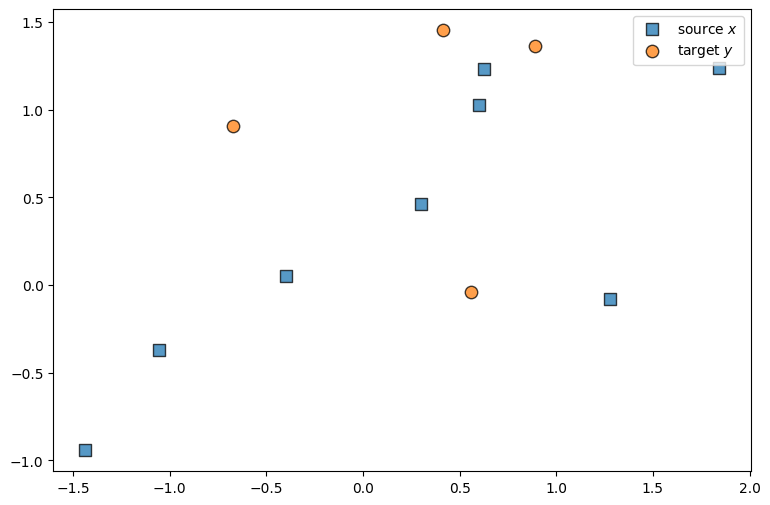

In [5]:
x_args = {
    "s": 80,
    "label": r"source $x$",
    "marker": "s",
    "edgecolor": "k",
    "alpha": 0.75,
}
y_args = {"s": 80, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
plt.figure(figsize=(9, 6))
plt.scatter(x_0[:, 0], x_0[:, 1], **x_args)
plt.scatter(x_1[:, 0], x_1[:, 1], **y_args)
plt.legend()
plt.show()

In [6]:
geom = pointcloud.PointCloud(x_0, x_1, cost_fn=None)
M = np.asarray(geom.cost_matrix)

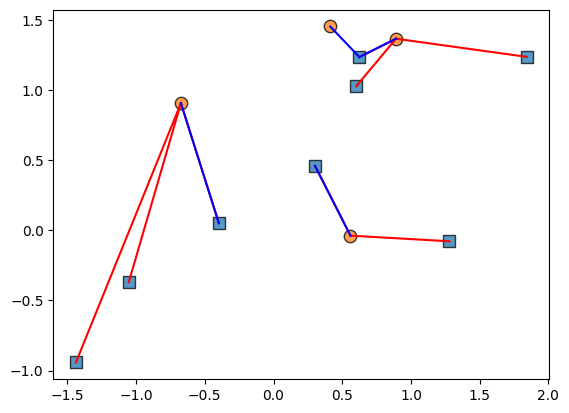

In [27]:
# For each point in x_0, find the nearest point in x_1
nbrs_0 = np.argmin(M, axis=1)
nbrs_1 = np.argmin(M, axis=0)

# connect the neighbor points
plt.clf()
plt.cla()
plt.scatter(x_0[:, 0], x_0[:, 1], **x_args)
plt.scatter(x_1[:, 0], x_1[:, 1], **y_args)
for i in range(n_0):
    plt.plot([x_0[i, 0], x_1[nbrs_0[i], 0]], [x_0[i, 1], x_1[nbrs_0[i], 1]], color="red")
for i in range(n_1):
    plt.plot([x_1[i, 0], x_0[nbrs_1[i], 0]], [x_1[i, 1], x_0[nbrs_1[i], 1]], color="blue")


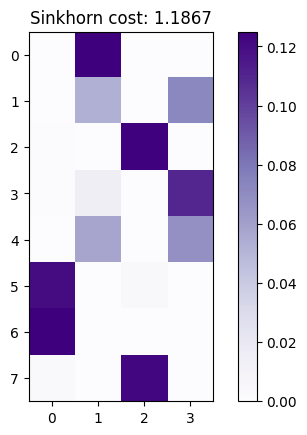

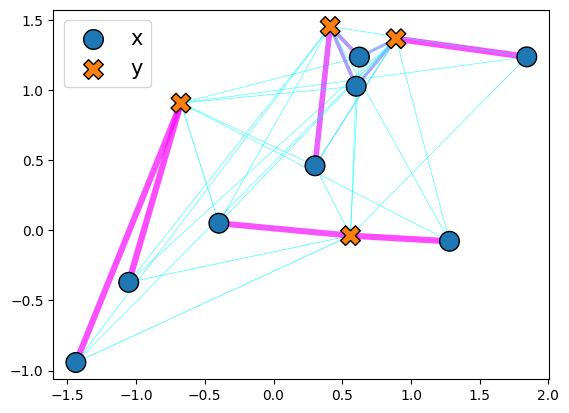

In [24]:
from ott.tools import plot
solve_fn = jax.jit(sinkhorn.solve)
sh = solve_fn(geom, a=None, b=None) # a, b are uniform distributions

plt.imshow(sh.matrix, cmap="Purples")
plt.title(f"Sinkhorn cost: {sh.primal_cost:.4f}")
plt.colorbar()
plt.show()
plott = plot.Plot()
_ = plott(sh)

In [26]:
sh.matrix

Array([[1.28503421e-16, 1.24998569e-01, 2.65194934e-32, 1.45778984e-06],
       [1.85191028e-13, 5.30775115e-02, 4.09678099e-16, 7.19225928e-02],
       [8.92161508e-04, 9.64456529e-17, 1.24107786e-01, 7.72814243e-11],
       [1.19149568e-03, 1.41111659e-02, 3.29491412e-09, 1.09697297e-01],
       [8.03923178e-11, 5.72996847e-02, 6.21627781e-15, 6.77002072e-02],
       [1.20071545e-01, 1.39378201e-07, 4.49594622e-03, 4.32356435e-04],
       [1.24736197e-01, 2.63737893e-04, 4.34564262e-22, 6.84283563e-08],
       [3.32755083e-03, 3.02232058e-24, 1.21672943e-01, 3.54368178e-17]],      dtype=float32)